# FLOW PREDICTION USING CNN

## MOUNTING DIRECTORY

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%pwd

'/content'

In [5]:
%cd "./drive/MyDrive/DeepCFD"

/content/drive/MyDrive/DeepCFD


In [6]:
%pwd

'/content/drive/MyDrive/DeepCFD'

## IMPORTING DEPENDENCIES

In [7]:
import os
import json
import torch
import pickle
from train_functions import *
from functions import *
import torch.optim as optim
from torch.utils.data import TensorDataset
from Models.UNetEx import UNetEx
import numpy as np

## DATA PREPROCESSING

In [8]:
    # Loading dataset
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x = pickle.load(open("./dataX.pkl", "rb"))
    y = pickle.load(open("./dataY.pkl", "rb"))
    x = torch.FloatTensor(x)
    y = torch.FloatTensor(y)   

    # Extracting Only The Binary Representation
    x = x[:,1,:,:]
    x = x.reshape(981, 1, 172, 79)
    print(x[0])
    print(x.size()) 
    channels_weights = torch.sqrt(torch.mean(y.permute(0, 2, 3, 1).reshape((981*172*79,3)) ** 2, dim=0)).view(1, -1, 1, 1).to(device)
    print(channels_weights)

tensor([[[2., 3., 3.,  ..., 3., 3., 2.],
         [2., 1., 1.,  ..., 1., 1., 2.],
         [2., 1., 1.,  ..., 1., 1., 2.],
         ...,
         [2., 1., 1.,  ..., 1., 1., 2.],
         [2., 1., 1.,  ..., 1., 1., 2.],
         [2., 4., 4.,  ..., 4., 4., 2.]]])
torch.Size([981, 1, 172, 79])
tensor([[[[0.1153]],

         [[0.0175]],

         [[0.0135]]]], device='cuda:0')


## STANDARD NN TRAINING

Epoch #1
	Train Loss = 57449636364288.0
	Train Total MSE = 758.7653374407798
	Train Ux MSE = 65.99554354386844
	Train Uy MSE = 624.8488413641126
	Train p MSE = 67.92093865308401
	Validation Loss = 6876391342080.0
	Validation Total MSE = 220.13758938029662
	Validation Ux MSE = 55.19515525688559
	Validation Uy MSE = 146.378757282839
	Validation p MSE = 18.56367621987553
Model saved!
Epoch #2
	Train Loss = 11440233480192.0
	Train Total MSE = 149.49131877220753
	Train Ux MSE = 48.38964238736789
	Train Uy MSE = 89.73252259190507
	Train p MSE = 11.369154215554106
	Validation Loss = 2549633875968.0
	Validation Total MSE = 81.68256753177967
	Validation Ux MSE = 46.0196967690678
	Validation Uy MSE = 28.684775969941736
	Validation p MSE = 6.978094999668962
Model saved!
Epoch #3
	Train Loss = 5644899237888.0
	Train Total MSE = 74.94701080767128
	Train Ux MSE = 44.96374600691281
	Train Uy MSE = 23.667593819754465
	Train p MSE = 6.315671047733407
	Validation Loss = 2022514278400.0
	Validation Total

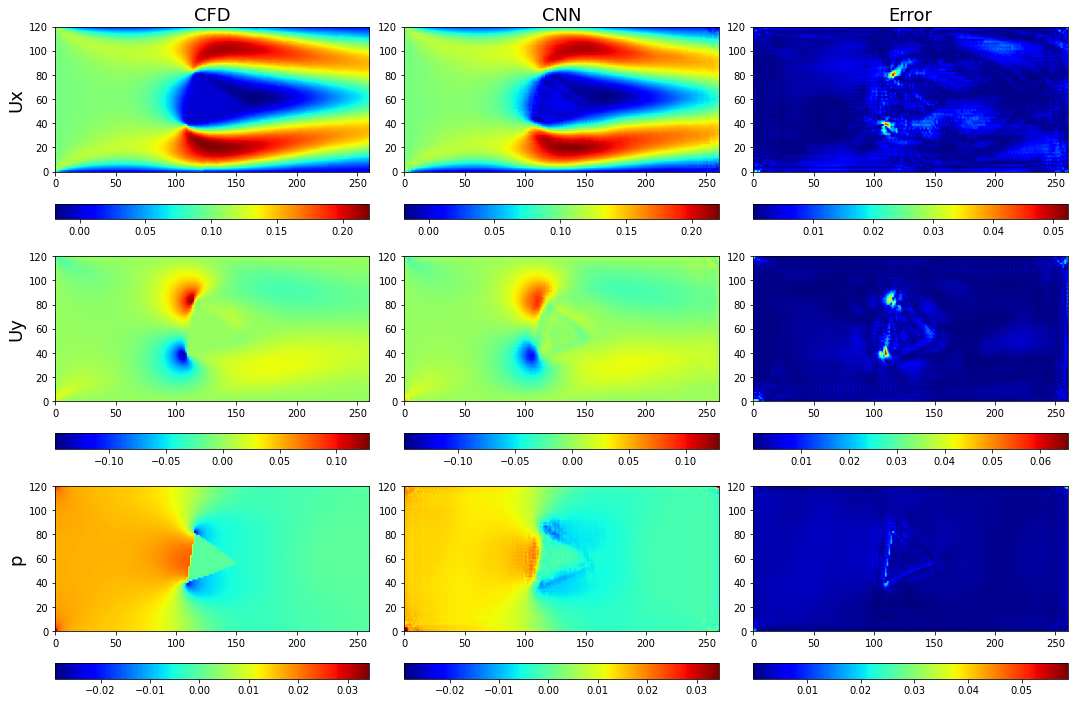

In [ ]:
simulation_directory = "./Run/"
if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)
    
# Spliting dataset into 70% train and 30% test
train_data, test_data = split_tensors(x, y, ratio=0.7)

train_dataset, test_dataset = TensorDataset(*train_data), TensorDataset(*test_data)        
test_x, test_y = test_dataset[:]

torch.manual_seed(0)
lr = 0.001
kernel_size = 5
filters = [8, 16, 32, 32]
bn = False
wn = False
wd = 0.005
# Considering only the binary input
#model = UNetEx(3, 3, filters=filters, kernel_size=kernel_size, batch_norm=bn, weight_norm=wn)
model = UNetEx(1, 3, filters=filters, kernel_size=kernel_size, batch_norm=bn, weight_norm=wn)

# Define opotimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd) 

config = {}        
train_loss_curve = []
test_loss_curve = []
train_mse_curve = []
test_mse_curve = []
train_ux_curve = []
test_ux_curve = []
train_uy_curve = []
test_uy_curve = []
train_p_curve = []
test_p_curve = []

def after_epoch(scope):
    train_loss_curve.append(scope["train_loss"])
    test_loss_curve.append(scope["val_loss"])
    train_mse_curve.append(scope["train_metrics"]["mse"])
    test_mse_curve.append(scope["val_metrics"]["mse"])
    train_ux_curve.append(scope["train_metrics"]["ux"])
    test_ux_curve.append(scope["val_metrics"]["ux"])
    train_uy_curve.append(scope["train_metrics"]["uy"])
    test_uy_curve.append(scope["val_metrics"]["uy"])
    train_p_curve.append(scope["train_metrics"]["p"])
    test_p_curve.append(scope["val_metrics"]["p"])

def loss_func(model, batch):
    x, y = batch
    output = model(x)
    lossu = ((output[:,0,:,:] - y[:,0,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3])) 
    lossv = ((output[:,1,:,:] - y[:,1,:,:]) ** 2).reshape((output.shape[0],1,output.shape[2],output.shape[3])) 
    lossp = torch.abs((output[:,2,:,:] - y[:,2,:,:])).reshape((output.shape[0],1,output.shape[2],output.shape[3])) 
    loss = (torch.sum(lossu) + torch.sum(lossv) + lossp)/channels_weights
    return torch.sum(loss), output

# Training model
# DeepCFD, train_metrics, train_loss, test_metrics, test_loss = train_model(model, loss_func, train_dataset, test_dataset, optimizer,
#     epochs=1000, batch_size=64, device=device,
#     m_mse_name="Total MSE",
#     m_mse_on_batch=lambda scope: float(torch.sum((scope["output"] - scope["batch"][1]) ** 2)),
#     m_mse_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
#     m_ux_name="Ux MSE",
#     m_ux_on_batch=lambda scope: float(torch.sum((scope["output"][:,0,:,:] - scope["batch"][1][:,0,:,:]) ** 2)),
#     m_ux_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
#     m_uy_name="Uy MSE",
#     m_uy_on_batch=lambda scope: float(torch.sum((scope["output"][:,1,:,:] - scope["batch"][1][:,1,:,:]) ** 2)),
#     m_uy_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
#     m_p_name="p MSE",
#     m_p_on_batch=lambda scope: float(torch.sum((scope["output"][:,2,:,:] - scope["batch"][1][:,2,:,:]) ** 2)),
#     m_p_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]), patience=25, after_epoch=after_epoch
#     )

# Training model only for 25 epochs
DeepCFD, train_metrics, train_loss, test_metrics, test_loss = train_model(model, loss_func, train_dataset, test_dataset, optimizer,
    epochs=100, batch_size=64, device=device,
    m_mse_name="Total MSE",
    m_mse_on_batch=lambda scope: float(torch.sum((scope["output"] - scope["batch"][1]) ** 2)),
    m_mse_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
    m_ux_name="Ux MSE",
    m_ux_on_batch=lambda scope: float(torch.sum((scope["output"][:,0,:,:] - scope["batch"][1][:,0,:,:]) ** 2)),
    m_ux_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
    m_uy_name="Uy MSE",
    m_uy_on_batch=lambda scope: float(torch.sum((scope["output"][:,1,:,:] - scope["batch"][1][:,1,:,:]) ** 2)),
    m_uy_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]),
    m_p_name="p MSE",
    m_p_on_batch=lambda scope: float(torch.sum((scope["output"][:,2,:,:] - scope["batch"][1][:,2,:,:]) ** 2)),
    m_p_on_epoch=lambda scope: sum(scope["list"]) / len(scope["dataset"]), patience=25, after_epoch=after_epoch
    )

    
metrics = {}
metrics["train_metrics"] = train_metrics
metrics["train_loss"] = train_loss
metrics["test_metrics"] = test_metrics
metrics["test_loss"] = test_loss
curves = {}
curves["train_loss_curve"] = train_loss_curve
curves["test_loss_curve"] = test_loss_curve
curves["train_mse_curve"] = train_mse_curve
curves["test_mse_curve"] = test_mse_curve
curves["train_ux_curve"] = train_ux_curve
curves["test_ux_curve"] = test_ux_curve
curves["train_uy_curve"] = train_uy_curve
curves["test_uy_curve"] = test_uy_curve
curves["train_p_curve"] = train_p_curve
curves["test_p_curve"] = test_p_curve
config["metrics"] = metrics
config["curves"] = curves
with open(simulation_directory + "results.json", "w") as file:
    json.dump(config, file)

out = DeepCFD(test_x[:10].to(device))
error = torch.abs(out.cpu() - test_y[:10].cpu())
s = 0
visualize(test_y[:10].cpu().detach().numpy(), out[:10].cpu().detach().numpy(), error[:10].cpu().detach().numpy(), s)

## PLOTTING

In [ ]:
# Plotting 10 predictions
out = DeepCFD(test_x[:10].to(device))
error = torch.abs(out.cpu() - test_y[:10].cpu())

for s in range(len(out)):
    visualize(test_y[:10].cpu().detach().numpy(), out.cpu().detach().numpy(), error.cpu().detach().numpy(), s)

Output hidden; open in https://colab.research.google.com to view.

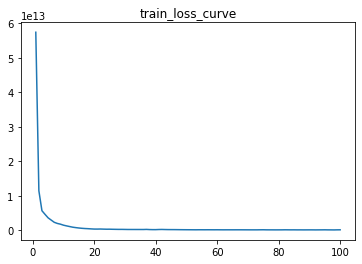

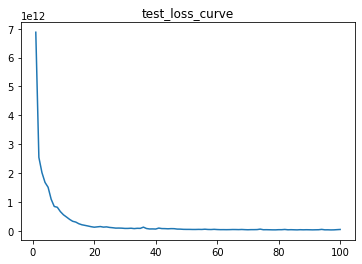

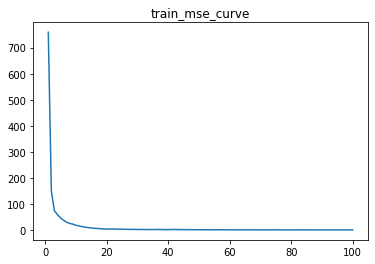

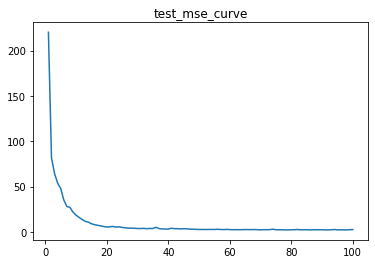

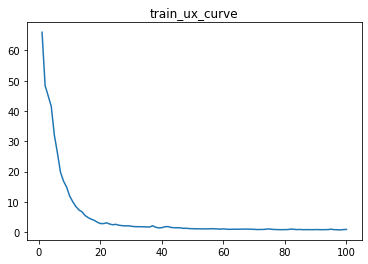

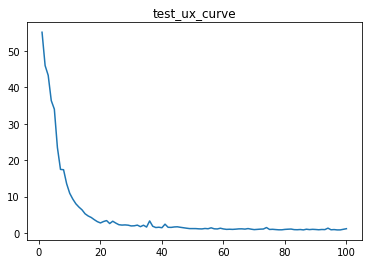

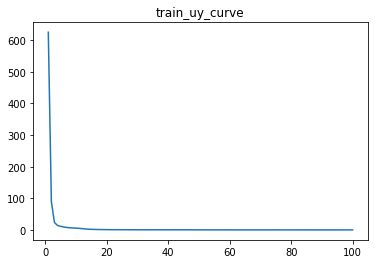

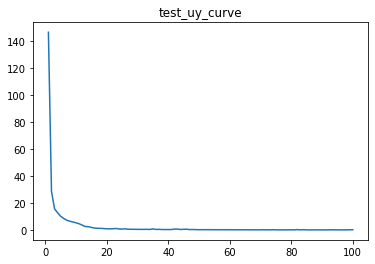

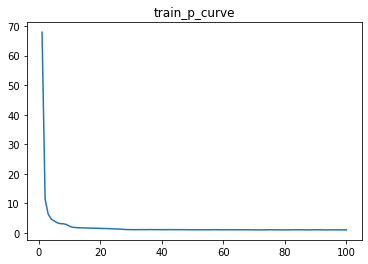

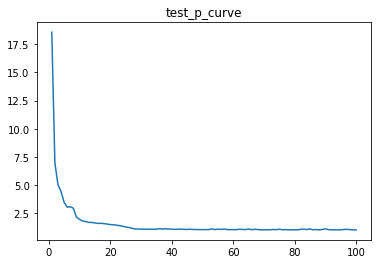

In [ ]:
import matplotlib.pyplot as plt
for key, val in curves.items():
    epcs = np.linspace(1, len(val), len(val))
    plt.figure()
    plt.plot(epcs, val)
    plt.title(key)

plt.show()